# Dependencies

In [1]:
import argparse

import os
import torch

import matplotlib.pyplot as plt
import numpy as np

from model.dataloader import HELMETDataLoader
from model.models import Darknet, load_weights, load_darknet_weights
from utils.utils import *

# Load in model

In [2]:
cfg_path = './cfg/yolov3.cfg'
weights_path = './weights/darknet53.conv.74'

In [3]:
### 

# Load in convolutional darknet.
# TODO: Set a default img_size for convenience.
def get_darknet(img_size, cfg=cfg_path):
    return Darknet(cfg, img_size)

# Load in weights

In [4]:
model = get_darknet(img_size=832)

In [5]:
load_darknet_weights(model, weights_path)

In [6]:
from model.dataloader import HELMETDataLoader
dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", shuffle=True, batch_size=6)

In [7]:
batch = next(iter(dataloader))

imgs, annotations = batch

print(imgs[0].shape)

out = model(imgs[0].reshape(1, 3, 832, 832))


print("output")
print(out)
print(out.shape)

torch.Size([3, 832, 832])
output
tensor([[[ 1.42607e+01,  1.16479e+01,  1.08923e+02,  ...,  4.73362e-01, -8.30614e-02,  6.23958e-01],
         [ 4.58485e+01,  1.16285e+01,  1.41514e+02,  ...,  4.07818e-01, -1.14826e-01, -4.13667e-01],
         [ 8.45615e+01,  1.82701e+01,  1.40011e+02,  ...,  3.87565e-01, -6.01462e-01,  1.64205e-01],
         ...,
         [ 8.13259e+02,  8.27846e+02,  1.95793e+01,  ...,  7.86071e-02, -8.04956e-02, -1.63067e-01],
         [ 8.19244e+02,  8.29124e+02,  2.40060e+01,  ...,  6.46830e-01, -6.98613e-01, -6.98011e-01],
         [ 8.27164e+02,  8.28407e+02,  3.32680e+01,  ..., -9.02497e-02,  3.97995e-01,  1.51354e-01]]])
torch.Size([1, 42588, 85])


# Detection "unit test"

In [8]:
# cuda = torch.cuda.is_available()
device = 'cpu' # device = torch.device('cuda:0' if cuda else 'cpu')

In [9]:
opt = {'conf_thres': .5, 
       'nms_thres': .45
      }

In [10]:
# os.system('rm -rf ' + opt.output_folder)
# os.makedirs(opt.output_folder, exist_ok=True)

model.to(device).eval()

# Set Dataloader
# classes = load_classes(opt.class_path)  # Extracts class labels from file
# dataloader = load_images(opt.image_folder, batch_size=opt.batch_size, img_size=opt.img_size)

imgs = []  # Stores image paths
img_detections = []  # Stores detections for each image index
# for batch_i, (img_paths, img) in enumerate(dataloader):
#     print(batch_i, img.shape, end=' ')

batch = next(iter(dataloader))

batch_imgs, batch_annotations = batch

# Get detections
with torch.no_grad():
    # chip = torch.from_numpy(img).unsqueeze(0).to(device)
    pred = model(batch_imgs[0].reshape(1, 3, 832, 832)) # pred = model(chip)
    pred = pred[pred[:, :, 4] > opt['conf_thres']]

    if len(pred) > 0:
        detections = non_max_suppression(pred.unsqueeze(0), opt['conf_thres'], opt['nms_thres'])
        img_detections.extend(detections)
        # imgs.extend(img_paths)

In [11]:
detections

[None]

(-0.5, 831.5, 831.5, -0.5)

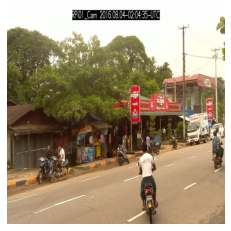

In [12]:
plt.imshow(np.array(batch_imgs[0]).transpose([1, 2, 0]))
plt.axis('off')

In [13]:
# Bugfix :D
model.to(device).train()
train_batch = torch.rand((3, 3, 832, 832))
targets = [ torch.tensor([[1, .5, .5, .2, .2], [1, .4, .4, .2, .2]]) ,  torch.tensor([[1, .5, .5, .2, .2]]) , torch.tensor([]) ]
model(train_batch, targets, requestPrecision=True)

C:\Users\runes\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
C:\Programming\Python\02456-deep-learning\Project\02456-yolo\model\models.py:156: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  tcls = tcls[mask]
C:\Programming\Python\02456-deep-learning\Project\02456-yolo\model\models.py:166: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  ..\aten\src\ATen/native/IndexingUtils.h:30.)
  lx = k * MSELoss(x[mask], tx[mask])
C:\Programming\Python\02456-deep-learning\Project\02456-yolo\model\models.py:167: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered

tensor([13.42943], grad_fn=<AddBackward0>)

# Dataloader

In [14]:
batch_size = 3

dataloader = HELMETDataLoader("./data/HELMET_DATASET_DUMMY", batch_size=batch_size, shuffle=True, resize=True)

# Train loop

In [15]:
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3,
    momentum=.9, weight_decay=5e-4, nesterov=True
)

Get device.

In [16]:
cuda = torch.cuda.is_available()
device = 'cpu' # device = torch.device('cuda:0' if cuda else 'cpu')

In [17]:
N_EPOCHS = 2
PLOT_EVERY = 1

model.to(device).train()
for epoch in range(1, N_EPOCHS + 1):
    imgs, targets = next(iter(dataloader))
    
    optimizer.zero_grad() # Zero gradients
    loss = model(imgs.to(device), targets, requestPrecision=True)
    loss.backward()
    optimizer.step()